# myAOAnet

In [1]:
import os
from os.path import join
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, accuracy_score
%matplotlib inline

## IQ data visualization

In [2]:
iq_data0 = pd.read_csv(join('data_1407', 'iq_example', 'log_long.csv'), sep=',', header=0)

In [3]:
iq_data = iq_data0.drop(iq_data0.columns[[index for index in range(11)]], axis = 1, inplace = False)
iq_data.shape

(20, 262144)

In [40]:
sample_id = 1
iq_data_np = iq_data.to_numpy()[sample_id, :]

In [41]:
iq_arr = iq_data_np.reshape(4, 32768, 2)

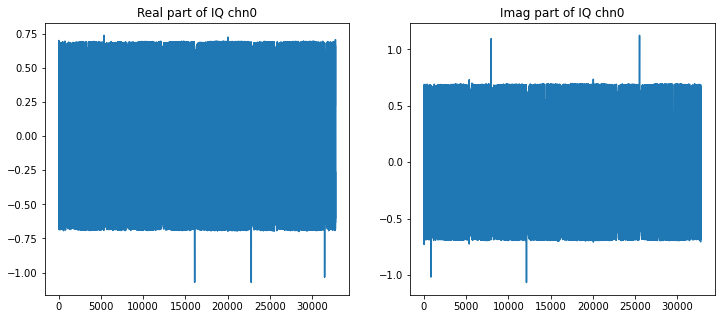

In [50]:
chn = 3

fig0 ,ax0 = plt.subplots(1, 2,figsize=(12,5))
ax0[0].plot(iq_arr[chn, :, 0])
ax0[0].set_title("Real part of IQ chn0")
ax0[1].plot(iq_arr[chn, :, 1])
ax0[1].set_title("Imag part of IQ chn0")
plt.show()

In [51]:
iq_amp = np.zeros((32768, 4))
iq_amp = np.sqrt(iq_arr[:, :, 0]**2 + iq_arr[:, :, 1]**2)
iq_amp.shape

(4, 32768)

In [52]:
iq_phase2 = np.zeros((32768, 4))
iq_phase2 = np.angle(iq_arr[:, :, 0] + iq_arr[:, :, 1]*1j)
iq_phase2.shape

(4, 32768)

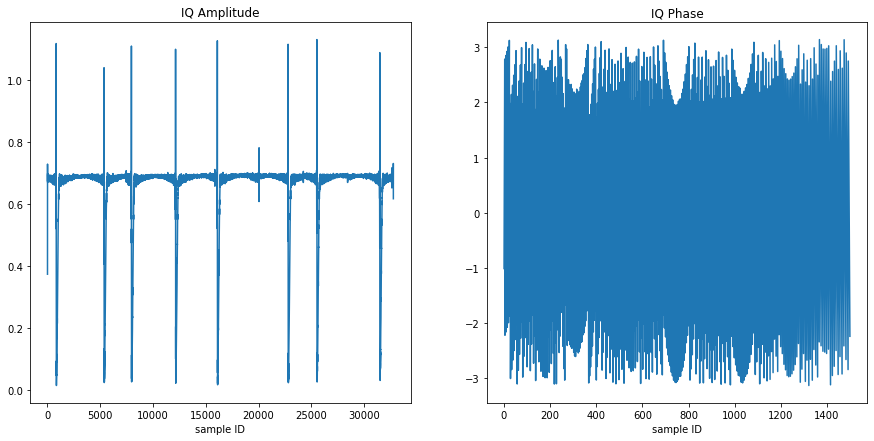

In [53]:
fig ,ax = plt.subplots(1, 2,figsize=(15,7))
ax[0].plot(iq_amp[chn, :])
ax[0].set_title("IQ Amplitude")
ax[0].set_xlabel("sample ID")
ax[1].plot(iq_phase2[chn, 11900:13400])
ax[1].set_title("IQ Phase")
ax[1].set_xlabel("sample ID")
plt.show()

## R-AOA Dataframe

In [54]:
data_dir = 'data_1407'
aoa_dict = {}
#fields_lst = ['field.data0', 'field.data1', 'field.data2', 'field.data3', 'field.data5', 'field.data6', 'field.data7', 'field.data10', 'field.data11', 'field.data15']
fields_lst = ['field.data0', 'field.data1', 'field.data2', 'field.data3', 'field.data4', 'field.data5', 'field.data6', 'field.data7', \
              'field.data10', 'field.data11', 'field.data12', 'field.data13', 'field.data14', 'field.data15', \
              'field.data20', 'field.data21', 'field.data22', 'field.data23', \
              'field.data30', 'field.data31']

for filename in os.listdir(data_dir):
    if filename.startswith("deg_m") and filename.endswith(".csv"):
        aoa = pd.read_csv(join(data_dir, filename), sep=',', header=0)
        aoa_Rjk = aoa[fields_lst]
        aoa_dict[- float(filename[5:-4])] = aoa_Rjk
    elif filename.startswith("deg_") and filename.endswith(".csv"):
        aoa = pd.read_csv(join(data_dir, filename), sep=',', header=0)
        aoa_Rjk = aoa[fields_lst]
        aoa_dict[float(filename[4:-4])] = aoa_Rjk

In [55]:
num_fields = aoa_dict[0].shape[1]
aoa_dict[-30].head(50)

,field.data0,field.data1,field.data2,field.data3,field.data4,field.data5,field.data6,field.data7,field.data10,field.data11,field.data12,field.data13,field.data14,field.data15,field.data20,field.data21,field.data22,field.data23,field.data30,field.data31
0,1.963472e-04,0.0,3.420485e-03,-1.717410e-03,7.716404e-03,1.669301e-04,2.001668e-03,9.132524e-03,0.074631,0.0,1.330573e-01,7.049957e-02,-4.492167e-02,1.765213e-01,0.305618,0.0,8.596320e-02,3.543335e-01,0.449455,0.0
1,1.868417e-04,0.0,3.256758e-03,-1.718457e-03,7.468002e-03,1.285264e-05,2.087011e-03,8.895741e-03,0.072612,0.0,1.301606e-01,6.903784e-02,-4.536977e-02,1.742290e-01,0.300919,0.0,8.358332e-02,3.523978e-01,0.451747,0.0
2,1.759345e-04,0.0,2.942627e-03,-1.864683e-03,7.152562e-03,-5.128154e-04,2.641202e-03,8.535551e-03,0.069028,0.0,1.251817e-01,6.735630e-02,-4.624381e-02,1.707343e-01,0.294648,0.0,8.200272e-02,3.517363e-01,0.458676,0.0
3,1.697410e-04,0.0,2.700827e-03,-1.999114e-03,6.975218e-03,-9.615416e-04,3.338996e-03,8.246395e-03,0.066569,0.0,1.224247e-01,6.697944e-02,-4.396053e-02,1.705680e-01,0.294300,0.0,9.005374e-02,3.550583e-01,0.471395,0.0
4,1.668835e-04,0.0,2.499101e-03,-2.095608e-03,6.788227e-03,-1.434888e-03,3.792061e-03,7.971464e-03,0.063770,0.0,1.197664e-01,6.386986e-02,-4.322537e-02,1.669473e-01,0.290923,0.0,8.516248e-02,3.535905e-01,0.472242,0.0
5,1.647286e-04,0.0,2.437480e-03,-2.128079e-03,6.792883e-03,-1.521960e-03,4.126763e-03,7.828357e-03,0.063580,0.0,1.202620e-01,6.534018e-02,-3.996463e-02,1.690686e-01,0.296488,0.0,9.729748e-02,3.578774e-01,0.480129,0.0
6,5.790829e-05,0.0,8.614124e-04,-7.407149e-04,2.387219e-03,-5.593330e-04,1.396104e-03,2.768597e-03,0.022306,0.0,4.271387e-02,2.225816e-02,-1.461946e-02,5.903463e-02,0.104624,0.0,3.064318e-02,1.266613e-01,0.167633,0.0
7,3.393638e-08,0.0,2.526209e-09,3.093468e-09,-4.212449e-08,-1.550139e-08,5.707005e-09,-1.749862e-08,0.000003,0.0,-4.705810e-08,-1.221413e-08,8.887911e-09,-4.323176e-08,0.000005,0.0,-1.849416e-08,1.875437e-07,0.000006,0.0
8,3.376205e-08,0.0,4.609884e-09,2.331133e-09,-4.193813e-08,-1.762240e-08,6.121841e-09,-1.476467e-08,0.000003,0.0,-6.077159e-08,2.712339e-08,-2.903884e-08,3.284289e-08,0.000005,0.0,3.246409e-08,8.300858e-08,0.000006,0.0
9,3.386505e-08,0.0,4.254896e-09,1.073868e-09,-4.334775e-08,-1.125957e-08,2.982290e-09,-1.641372e-08,0.000003,0.0,-5.913307e-08,9.658708e-10,-1.865210e-08,-2.051109e-08,0.000005,0.0,-3.750303e-08,7.941380e-08,0.000006,0.0


In [56]:
#Degree to Radian
for key in aoa_dict.keys():
    aoa_dict[key]['theta'] = key * math.pi / 180

# Show detection of LoRa beacon when Rjk is significant
field_thres = 1e-04

for key in aoa_dict.keys():
    print("%s shape of signal-presenting snapshots = %.01f" % (str(aoa_dict[key][abs(aoa_dict[key]['field.data2']) >= field_thres].shape), key))

(195, 21) shape of signal-presenting snapshots = 0.0
(176, 21) shape of signal-presenting snapshots = 60.0
(162, 21) shape of signal-presenting snapshots = -50.0
(193, 21) shape of signal-presenting snapshots = -60.0
(215, 21) shape of signal-presenting snapshots = -40.0
(225, 21) shape of signal-presenting snapshots = 20.0
(89, 21) shape of signal-presenting snapshots = 70.0
(219, 21) shape of signal-presenting snapshots = 40.0
(203, 21) shape of signal-presenting snapshots = 30.0
(209, 21) shape of signal-presenting snapshots = -30.0
(205, 21) shape of signal-presenting snapshots = -70.0
(199, 21) shape of signal-presenting snapshots = -20.0
(159, 21) shape of signal-presenting snapshots = 10.0
(191, 21) shape of signal-presenting snapshots = -10.0
(213, 21) shape of signal-presenting snapshots = 50.0


/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [57]:
# Differentiate R of LoRa signal or noise
aoa_sig, aoa_noi = {}, {}
sig_index_lst = {}

for key in aoa_dict.keys():
    aoa_sig[key] = aoa_dict[key].drop(aoa_dict[key][abs(aoa_dict[key]['field.data2']) < field_thres].index)
    aoa_noi[key] = aoa_dict[key].drop(aoa_dict[key][abs(aoa_dict[key]['field.data2']) >= field_thres].index)
    
    sig_index_lst[key] = (aoa_dict[key][abs(aoa_dict[key]['field.data2']) >= field_thres].index)
    
sig_index_lst[-10]

Int64Index([ 19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
            ...
            682, 683, 684, 685, 686, 687, 688, 689, 690, 691],
           dtype='int64', length=191)

In [58]:
# Save sig_index!
import pickle

with open(join(data_dir, 'df_collection', 'sig_index.pkl'), "wb") as a_file:
    pickle.dump(sig_index_lst, a_file)

In [118]:
# Load sig index
import pickle

with open(join(data_dir, 'df_collection', 'sig_index.pkl'), "rb") as a_file:
    sig_index_lst = pickle.load(a_file)

In [59]:
# Xaoa = aoa_sig <-> theta[Rad]
Xaoa = pd.concat([aoa_sig[rad] for rad in range(-70, 80, 10)], keys=[rad for rad in range(-70, 80, 10)], names=['Series name', 'Row ID'])
idx = pd.IndexSlice

In [60]:
print(Xaoa.shape)
Xaoa.loc[idx[[-10, 0, 30, 70], :], :]
Xaoa

(2853, 21)


field.data0  field.data1  field.data2  field.data3  \
Series name Row ID                                                       
-70         78         0.000418          0.0     0.002510     0.004877   
            79         0.001096          0.0     0.006674     0.012728   
            80         0.001094          0.0     0.006713     0.012636   
            81         0.001093          0.0     0.006657     0.012612   
            82         0.001114          0.0     0.006839     0.012809   
...                         ...          ...          ...          ...   
 70         343        0.000837          0.0    -0.001129     0.006298   
            344        0.000768          0.0    -0.001402     0.006189   
            346        0.000619          0.0    -0.000885     0.003574   
            347        0.000698          0.0    -0.002030     0.004162   
            348        0.000246          0.0    -0.000693     0.001338   

                    field.data4  field.data5  field.data6  field.data7  \
Series name Row ID                                                       
-70         78        -0.004817     0.005768    -0.001256    -0.006939   
            79        -0.012502     0.015165    -0.003476    -0.018084   
            80        -0.012395     0.015100    -0.003574    -0.017925   
            81        -0.012374     0.015034    -0.003456    -0.017845   
            82        -0.012417     0.015377    -0.003514    -0.018142   
...                         ...          ...          ...          ...   
 70         343        0.000326     0.017236     0.013090    -0.008875   
            344        0.000250     0.016565     0.013080    -0.008058   
            346       -0.000260     0.011450     0.008509    -0.006619   
            347       -0.002124     0.013263     0.010427    -0.006039   
            348       -0.000869     0.004648     0.003914    -0.001789   

                    field.data10  field.data11  ...  field.data13  \
Series name Row ID                              ...                 
-70         78          0.071988           0.0  ...      0.090913   
            79          0.188567           0.0  ...      0.237855   
            80          0.187113           0.0  ...      0.235974   
            81          0.186046           0.0  ...      0.234491   
            82          0.189401           0.0  ...      0.237503   
...                          ...           ...  ...           ...   
 70         343         0.049111           0.0  ...     -0.025766   
            344         0.052725           0.0  ...     -0.032442   
            346         0.022160           0.0  ...     -0.015080   
            347         0.030814           0.0  ...     -0.026040   
            348         0.009255           0.0  ...     -0.008404   

                    field.data14  field.data15  field.data20  field.data21  \
Series name Row ID                                                           
-70         78         -0.088393     -0.027005      0.136315           0.0   
            79         -0.231009     -0.069784      0.355724           0.0   
            80         -0.228594     -0.068686      0.351850           0.0   
            81         -0.226579     -0.068776      0.350057           0.0   
            82         -0.230021     -0.071002      0.353812           0.0   
...                          ...           ...           ...           ...   
 70         343        -0.084525     -0.086747      0.358759           0.0   
            344        -0.089064     -0.091155      0.362142           0.0   
            346        -0.050514     -0.039927      0.214202           0.0   
            347        -0.066423     -0.044758      0.260713           0.0   
            348        -0.020773     -0.016263      0.091632           0.0   

                    field.data22  field.data23  field.data30  field.data31  \
Series name Row ID                                                           
-70         78         -0

In [61]:
Xaoa.to_csv(join(data_dir, 'df_collection', 'Xraw.csv'), index=True, header=True)

### MUSIC

In [62]:
# Notice Noisy Rosbags do not contain 'kerberos/doa_results'
#data_dir = 'data_0107'
music_dict = {}

for filename in os.listdir(data_dir):
    if filename.startswith("music_deg_m") and filename.endswith(".csv"):
        music_deg = pd.read_csv(join(data_dir, filename), sep=',', header=0)
        music_deg.rename(columns = {'field.data': 'music'}, inplace=True)
        music_series = music_deg['music']
        music_dict[- float(filename[11:-4])] = music_series
    elif filename.startswith("music_deg_") and filename.endswith(".csv"):
        music_deg = pd.read_csv(join(data_dir, filename), sep=',', header=0)
        music_deg.rename(columns = {'field.data': 'music'}, inplace=True)
        music_series = music_deg['music']
        music_dict[float(filename[10:-4])] = music_series

In [63]:
for key in music_dict.keys():
    music_dict[key] = music_dict[key][sig_index_lst[key]]

In [64]:
# Add MUSIC_results as 22nd column
Xmusic = pd.concat([music_dict[rad] for rad in range(-70, 80, 10)], keys=[rad for rad in range(-70, 80, 10)], names=['Series name', 'Row ID'])
Xaoa_music = pd.concat([Xaoa, Xmusic], axis=1)
Xmusic

Series name  Row ID
-70          78        326.0
             79        332.0
             80        332.0
             81        332.0
             82        332.0
                       ...  
 70          343        22.0
             344        24.0
             346        24.0
             347        27.0
             348        27.0
Name: music, Length: 2853, dtype: float64

In [65]:
print(data_dir)
Xmusic.to_csv(join(data_dir, 'df_collection', 'music_series.csv'), index=True, header=True)

data_1407


In [66]:
Xaoa_music.to_csv(join(data_dir, 'df_collection', 'Xaoa_music.csv'), index=True, header=True)

## Create Origin-Noisy-MUSIC dataset

In [67]:
#field_thres = 1e-04

def create_dataset(dirname, sigma, Xmusic, sig_index_lst):
    aoa_dict = {}
    #fields_lst = ['field.data0', 'field.data1', 'field.data2', 'field.data3', 'field.data5', 'field.data6', 'field.data7', 'field.data10', 'field.data11', 'field.data15']
    fields_lst = ['field.data0', 'field.data1', 'field.data2', 'field.data3', 'field.data4', 'field.data5', 'field.data6', 'field.data7', \
                  'field.data10', 'field.data11', 'field.data12', 'field.data13', 'field.data14', 'field.data15', \
                  'field.data20', 'field.data21', 'field.data22', 'field.data23', \
                  'field.data30', 'field.data31']

    for filename in os.listdir(dirname):
        if filename.startswith("deg_m") and filename.endswith("_" + sigma + ".csv"):
            aoa = pd.read_csv(join(dirname, filename), sep=',', header=0)
            aoa_Rjk = aoa[fields_lst]
            aoa_dict[- float(filename[5:-9])] = aoa_Rjk
        elif filename.startswith("deg_") and filename.endswith("_" + sigma + ".csv"):
            aoa = pd.read_csv(join(dirname, filename), sep=',', header=0)
            aoa_Rjk = aoa[fields_lst]
            aoa_dict[float(filename[4:-9])] = aoa_Rjk
    
    aoa_sig, aoa_noi = {}, {}
    #sig_index_lst = {}
            
    for key in aoa_dict.keys():
        aoa_dict[key]['theta'] = key * math.pi / 180
        #print(key ,aoa_dict[key].shape)
        #print(sig_index_lst[key])
        
        # Patch: cut positional idx that are out-of-bound
        #slice_idx = sig_index_lst[key]
        #slice_idx = slice_idx[slice_idx<len(sig_index_lst[key])]
        try:
            aoa_sig[key] = aoa_dict[key].iloc[sig_index_lst[key], :]
        except IndexError:
            aoa_sig[key] = aoa_dict[key].iloc[sig_index_lst[key][:-3], :]
    
    Xaoa_noi = pd.concat([aoa_sig[rad] for rad in range(-70, 80, 10)], \
                     keys=[rad for rad in range(-70, 80, 10)], names=['Series name', 'Row ID'])
    
    Xaoa_noi_music = pd.concat([Xaoa_noi, Xmusic], axis=1)
    return Xaoa_noi_music
    

In [68]:
# trick: slice pd.Int64Index
sig_index_lst[10][:-1]

Int64Index([  1,  26,  27,  28,  29,  30,  31,  32,  33,  35,
            ...
            692, 723, 724, 725, 726, 727, 728, 729, 759, 760],
           dtype='int64', length=158)

In [99]:
import pickle

noi_dir_lst = ['noisy1', 'noisy2', 'noisy3', 'noisy4', 'noisy5']
#noi_dir_lst = []

def get_X_list(dirname):
    Xaoa_music = pd.read_csv(join(dirname, 'df_collection', 'Xaoa_music.csv'), index_col=[0, 1])
    Xnoisy_parts = [Xaoa_music]
    with open(join(dirname, 'df_collection', 'sig_index.pkl'), "rb") as a_file:
        sig_index_lst = pickle.load(a_file)
        
    Xmusic = pd.read_csv(join(dirname, 'df_collection', 'music_series.csv'), index_col=[0, 1])
    
    for noi_dir in noi_dir_lst:
        noisy_dir = join(dirname, noi_dir)
        
        Xnoisy_parts.append(create_dataset(noisy_dir, '1e_5', Xmusic, sig_index_lst))
        Xnoisy_parts.append(create_dataset(noisy_dir, '5e_5', Xmusic, sig_index_lst))
        Xnoisy_parts.append(create_dataset(noisy_dir, '1e_4', Xmusic, sig_index_lst))
        Xnoisy_parts.append(create_dataset(noisy_dir, '5e_4', Xmusic, sig_index_lst))

    return Xnoisy_parts

#X_1407 = get_X_list('data_1407')
#'''
X_0207 = get_X_list('data_0207')
X_0107 = get_X_list('data_0107')
X_1606 = get_X_list('data_1606')
#'''

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [100]:
X = X_1606 + X_0107 + X_0207
#X = X_1407
X1 = X_1407

print(len(X))
X[0].head(20)

63


field.data0  field.data1  field.data2  field.data3  \
Series name Row ID                                                       
-70         0          0.000046          0.0     0.002728     0.000348   
            1          0.000032          0.0     0.002230     0.000289   
            2          0.000008          0.0     0.000627     0.000079   
            27         0.000004          0.0     0.000310     0.000150   
            28         0.000120          0.0    -0.000454    -0.003152   
            29         0.000464          0.0    -0.006122    -0.000039   
            30         0.000519          0.0    -0.005092     0.006812   
            31         0.000481          0.0    -0.001118     0.009971   
            32         0.000110          0.0    -0.001813     0.003157   
            33         0.000306          0.0    -0.001411     0.006338   
            34         0.000440          0.0    -0.003908     0.007889   
            35         0.000183          0.0    -0.004913     0.002114   
            36         0.000171          0.0    -0.004778    -0.000071   
            37         0.000083          0.0    -0.002738     0.000520   
            62         0.000017          0.0     0.000267     0.001363   
            63         0.000026          0.0     0.000441     0.002146   
            64         0.000027          0.0     0.000320     0.002174   
            65         0.000027          0.0     0.000323     0.002192   
            67         0.000025          0.0    -0.000258     0.002088   
            68         0.000026          0.0    -0.000198     0.002168   

                    field.data4  field.data5  field.data6  field.data7  \
Series name Row ID                                                       
-70         0          0.001615    -0.000416     0.001171    -0.000044   
            1          0.001354    -0.000339     0.001016    -0.000039   
            2          0.000384    -0.000098     0.000293    -0.000017   
            27         0.000223     0.000034     0.000113     0.000085   
            28        -0.000799    -0.001858     0.000271    -0.001878   
            29        -0.003498     0.001458    -0.001950    -0.001995   
            30        -0.002057     0.005848    -0.002810     0.001495   
            31         0.000050     0.006908    -0.003182     0.003371   
            32        -0.001001     0.002145    -0.002003     0.000582   
            33        -0.000078     0.003641    -0.002418     0.000670   
            34        -0.001748     0.006017    -0.003919     0.002384   
            35        -0.002778     0.002981    -0.002362     0.001082   
            36        -0.002988     0.001366    -0.001942    -0.000016   
            37        -0.001678     0.000946    -0.001223     0.000006   
            62         0.000509     0.000670     0.000198     0.000316   
            63         0.000807     0.001054     0.000311     0.000514   
            64         0.000747     0.001110     0.000287     0.000557   
            65         0.000764     0.001122     0.000302     0.000569   
            67         0.000422     0.001245     0.000160     0.000621   
            68         0.000462     0.001278     0.000183     0.000642   

                    field.data10  field.data11  ...  field.data14  \
Series name Row ID                              ...                 
-70         0           0.165659           0.0  ...      0.069720   
            1           0.161718           0.0  ...      0.072078   
            2           0.050502           0.0  ...      0.023049   
            27          0.028097           0.0  ...      0.011273   
            28          0.165926           0.0  ...      0.082327   
            29          0.094349           0.0  ...      0.032767   
            30          0.146118           0.0  ...      0.048959   
            31          0.215421           0.0  ...      0.078268   
            32          0.188726           0.0  ...      0.077243   
   

In [112]:
#new_col = ['r11', 'r12', 'r13', 'r14', 'r22', 'r23', 'r24', 'r33', 'r34', 'r44']
new_col = ['r12', 'r13', 'r14', 'r23', 'r24', 'r34']
fields_lst = ['field.data0', 'field.data1', 'field.data2', 'field.data3', 'field.data4', 'field.data5', 'field.data6', 'field.data7', \
                  'field.data10', 'field.data11', 'field.data12', 'field.data13', 'field.data14', 'field.data15', \
                  'field.data20', 'field.data21', 'field.data22', 'field.data23', \
                  'field.data30', 'field.data31']

def create_Xphs_Xamp(X):
    Xdata = X[fields_lst]
    Xnew = X.drop(fields_lst, axis=1)
    Xamp = Xnew.copy(deep=True)
    
    for i, col in enumerate(new_col):
        
        val = np.angle(Xdata.iloc[:, 2*i] + 1j*Xdata.iloc[:, 2*i+1])
        Xnew.insert(loc=i, column=col, value=val)
        
        amp = np.sqrt(Xdata.iloc[:, 2*i]**2 + Xdata.iloc[:, 2*i+1]**2)
        Xamp.insert(loc=i, column=col, value=amp)
        
    return Xnew, Xamp

In [113]:
# R_Phase diagonal components are 0s!
Xphs, Xamp = [], []
for item in X:
    phs, amp = create_Xphs_Xamp(item)
    Xphs.append(phs)
    Xamp.append(amp)

In [114]:
print(len(Xphs))
Xphs[0].head()

3


r12       r13       r14       r23  r24       r34    theta  \
Series name Row ID                                                              
-70         0       0.0  0.126784 -0.252197 -0.037714  0.0 -0.383391 -1.22173   
            1       0.0  0.128808 -0.245366 -0.038369  0.0 -0.379936 -1.22173   
            2       0.0  0.125344 -0.249574 -0.058257  0.0 -0.380050 -1.22173   
            27      0.0  0.450013  0.153152  0.644738  0.0 -0.297237 -1.22173   
            28      0.0 -1.713807 -1.976802 -1.427552  0.0 -0.281988 -1.22173   

                    music  
Series name Row ID         
-70         0         2.0  
            1         2.0  
            2         2.0  
            27      359.0  
            28      359.0

In [115]:
# Save 'Xphs' of Rjk instead
import pickle

with open(join('Data', 'pureXphs.pkl'), 'wb') as a_file:
    pickle.dump(Xphs, a_file)

In [116]:
# Save Real & Image parts of Rjk
with open(join('Data', 'pureX.pkl'), 'wb') as a_file:
    pickle.dump(X, a_file)

### Save/Load .pkl to a list of DataFrame

In [69]:
# Load X (a list)
import pickle

with open(join('Data', 'Xphs.pkl'), 'rb') as a_file:
    Xphs = pickle.load(a_file)
    
with open(join('Data', 'X.pkl'), 'rb') as a_file:
    X = pickle.load(a_file)

In [101]:
import pickle
'''
df_lst = []
sig_idx_lst = []
load_lst = ['data_1606', 'data_0107', 'data_0207']

for load_dir in load_lst:
    for filename in os.listdir(join(load_dir, 'df_collection')):
        if filename.startswith("LOS") and filename.endswith("ALL.csv"):
            print(load_dir, filename)
            Xaoa0 = pd.read_csv(join(load_dir, 'df_collection', filename), index_col=[0, 1])
            df_lst.append(Xaoa0)
            with open(join(load_dir, 'df_collection', 'sig_index.pkl'), "rb") as a_file:
                sig_idx_lst.append(pickle.load(a_file))
'''

len(X)

63

In [ ]:
# Use R_phase as input instead
'''
df_lst = []
load_lst = ['data_1606', 'data_0107', 'data_0207']

for load_dir in load_lst:
    for filename in os.listdir(join(load_dir, 'df_collection')):
        if filename.startswith("PHS_LOS") and filename.endswith("ALL.csv"):
            print(load_dir, filename)
            Xaoa0 = pd.read_csv(join(load_dir, 'df_collection', filename), index_col=[0, 1])
            df_lst.append(Xaoa0)
'''

In [24]:
df_lst[2].shape

(54726, 22)

In [102]:
# Slicing Example
idx = pd.IndexSlice
X[0].loc[idx[-30, :20], :]

field.data0  field.data1  field.data2  field.data3  \
Series name Row ID                                                       
-30         4          0.004537          0.0     0.019305    -0.010193   
            5          0.007078          0.0     0.030401    -0.016007   
            6          0.007035          0.0     0.030353    -0.015765   
            7          0.007096          0.0     0.030577    -0.015770   
            8          0.007042          0.0     0.030518    -0.015511   
            9          0.007052          0.0     0.030552    -0.015541   
            10         0.007049          0.0     0.030387    -0.015734   
            11         0.007076          0.0     0.030488    -0.015709   
            12         0.006998          0.0     0.030128    -0.015725   
            13         0.007087          0.0     0.030281    -0.016114   
            14         0.000779          0.0     0.003335    -0.001752   

                    field.data4  field.data5  field.data6  field.data7  \
Series name Row ID                                                       
-30         4         -0.008209     0.000556    -0.014722     0.010581   
            5         -0.013366     0.001186    -0.024114     0.017374   
            6         -0.013744     0.001671    -0.024870     0.018445   
            7         -0.014181     0.002197    -0.025630     0.019559   
            8         -0.014187     0.002329    -0.025864     0.019582   
            9         -0.013987     0.002054    -0.025796     0.019076   
            10        -0.013990     0.001606    -0.025913     0.018328   
            11        -0.013824     0.001449    -0.025552     0.017951   
            12        -0.013351     0.000735    -0.024636     0.016547   
            13        -0.012895     0.000175    -0.023782     0.015731   
            14        -0.001369     0.000010    -0.002531     0.001696   

                    field.data10  field.data11  ...  field.data14  \
Series name Row ID                              ...                 
-30         4           0.106066           0.0  ...     -0.086929   
            5           0.168295           0.0  ...     -0.143603   
            6           0.167899           0.0  ...     -0.149522   
            7           0.168429           0.0  ...     -0.154849   
            8           0.168021           0.0  ...     -0.156165   
            9           0.168222           0.0  ...     -0.154735   
            10          0.167720           0.0  ...     -0.153520   
            11          0.167807           0.0  ...     -0.150802   
            12          0.166609           0.0  ...     -0.144045   
            13          0.167590           0.0  ...     -0.138187   
            14          0.018422           0.0  ...     -0.014758   

                    field.data15  field.data20  field.data21  field.data22  \
Series name Row ID                                                           
-30         4           0.012012      0.015093           0.0      0.028198   
            5           0.020189      0.025719           0.0      0.048879   
            6           0.023982      0.027561           0.0      0.053468   
            7           0.027481      0.029348           0.0      0.057813   
            8           0.028044      0.029681           0.0      0.059124   
            9           0.025939      0.028662           0.0      0.057251   
            10          0.021290      0.028449           0.0      0.056121   
            11          0.020733      0.027611           0.0      0.054088   
            12          0.015974      0.025852           0.0      0.049208   
            13          0.013221      0.023735           0.0      0.044078   
            14          0.001581      0.002440           0.0      0.004517   

                    field.data23  field.data30  field.data31     theta  music  
Series name Row ID                                                             
-30         4        

## Preparation

### Create training data with Clean & Noisy datasets

In [35]:
# Corrupt R directly!?
'''
noise = np.random.normal(0, 0.0001, Xaoa.shape)
Xaoa_noisy = Xaoa + noise
'''

In [74]:
def Split_TimeSeries3(Xaoa, aoa_gt_series=range(-70, 80, 10), feature_space=20):
    # Xarr: time series of Rjk
    Xaoa_cpy = Xaoa.copy(deep=True)

    Xarr, ylst = np.empty((0, 3, feature_space), dtype='float32'), []
    rowt_0, rowt_1, rowt_2 = None, None, None
    row_up, row_mid, row_down = -1, -1, -1

    for serName in aoa_gt_series:
        isFirstRow = True
        isSecRow = True
        for rowId, row in Xaoa_cpy.loc[serName].iterrows():
            row_up = row_mid
            rowt_2 = rowt_1
            row_mid = row_down
            rowt_1 = rowt_0
            row_down = rowId
            
            rowt_0 = row.drop(['theta', 'music']).to_numpy(dtype='float32').reshape(1, 1, feature_space)
            if isFirstRow:
                isFirstRow = False
                continue

            if isSecRow:
                isSecRow = False
                continue

            if row_down-row_mid==1 and row_mid-row_up==1:
                arr_tmp = np.concatenate((rowt_2, rowt_1, rowt_0), axis=1)

                Xarr = np.append(Xarr, arr_tmp, axis=0)
                ylst.append([row['theta'], row['music']])

    # Xvec: slice of a Rjk row
    Xvec = Xaoa_cpy.drop(['theta', 'music'], axis=1).to_numpy()
    yvec = Xaoa_cpy[['theta', 'music']].to_numpy()
                
    #print(Xarr.shape, len(ylst))
    return Xarr, ylst, Xvec, yvec

Convert Clean & Noisy Dataframes into Numpy.Array where (3) coherent snapshots should be grouped

In [103]:
# Use R_(real,imag) as input features
Xarr = np.array([])
yarr = np.array([])
Xvec = np.array([])
yvec = np.array([])

for item in X:
    Xarr0, ylst0, Xvec0, yvec0 = Split_TimeSeries3(item)
    
    Xarr = np.concatenate((Xarr, Xarr0), axis=0) if Xarr.size else Xarr0
    Xvec = np.concatenate((Xvec, Xvec0), axis=0) if Xvec.size else Xvec0
    yvec = np.concatenate((yvec, yvec0), axis=0) if yvec.size else yvec0
    yarr0 = np.array(ylst0)
    yarr = np.concatenate((yarr, yarr0), axis=0) if yarr.size else yarr0

print(Xarr.shape)
print(yarr.shape)
print(Xvec.shape)
print(yvec.shape)

(156723, 3, 20)
(156723, 2)
(196602, 20)
(196602, 2)


In [104]:
# Use R_(real,imag) of unseen X1 as input features
Xarr1 = np.array([])
yarr1 = np.array([])
Xvec1 = np.array([])
yvec1 = np.array([])

for item in X1:
    Xarr0, ylst0, Xvec0, yvec0 = Split_TimeSeries3(item)
    
    Xarr1 = np.concatenate((Xarr1, Xarr0), axis=0) if Xarr1.size else Xarr0
    Xvec1 = np.concatenate((Xvec1, Xvec0), axis=0) if Xvec1.size else Xvec0
    yvec1 = np.concatenate((yvec1, yvec0), axis=0) if yvec1.size else yvec0
    yarr0 = np.array(ylst0)
    yarr1 = np.concatenate((yarr1, yarr0), axis=0) if yarr1.size else yarr0

print(Xarr1.shape)
print(yarr1.shape)
print(Xvec1.shape)
print(yvec1.shape)

(2230, 3, 20)
(2230, 2)
(2853, 20)
(2853, 2)


In [20]:
# Use R_phase data instead
Xarr = np.array([])
yarr = np.array([])
Xvec = np.array([])
yvec = np.array([])

for item in Xphs:
    Xarr0, ylst0, Xvec0, yvec0 = Split_TimeSeries3(item, feature_space=6)
    
    Xarr = np.concatenate((Xarr, Xarr0), axis=0) if Xarr.size else Xarr0
    Xvec = np.concatenate((Xvec, Xvec0), axis=0) if Xvec.size else Xvec0
    yvec = np.concatenate((yvec, yvec0), axis=0) if yvec.size else yvec0
    yarr0 = np.array(ylst0)
    yarr = np.concatenate((yarr, yarr0), axis=0) if yarr.size else yarr0

print(Xarr.shape)
print(yarr.shape)
print(Xvec.shape)
print(yvec.shape)

(156723, 3, 6)
(156723, 2)
(196602, 6)
(196602, 2)


### Split train/test data

In [106]:
# Check if any 'NAN'
yarr1[np.isnan(yarr1)]

array([], dtype=float64)

In [107]:
# Remove 'NAN' in datasets!
Xvec_clean = Xvec[~np.isnan(Xvec).any(axis=1)]
Xvec_clean.shape

(196578, 20)

In [108]:
yvec_clean = yvec[~np.isnan(yvec).any(axis=1)]
yvec_clean.shape

(196578, 2)

In [109]:
# Remove 'NAN' in datasets!
Xarr_clean = Xarr[~np.isnan(Xarr).any(axis=(1,2))]
print(Xarr_clean.shape)
yarr_clean = yarr[~np.isnan(yarr).any(axis=1)]
print(yarr_clean.shape)

(156699, 3, 20)
(156699, 2)


In [110]:
# SHUFFLE!
X_train, X_test, y_train, y_test = train_test_split(Xarr_clean, yarr_clean, test_size=0.25, random_state=42)

In [111]:
y_test.shape

(39175, 2)

In [112]:
# Split Label (theta) and y_train/test_music (music) from yarr
y_test_music = []
for item in y_test:
    if item[1] > 180.0:
        item[1] -= 360
    y_test_music.append(item[1])
y_train_music = []
for item in y_train:
    if item[1] > 180.0:
        item[1] -= 360
    y_train_music.append(item[1])

y_train = [item[0] for item in y_train]
y_test = [item[0] for item in y_test]

In [113]:
print(max(y_train_music), min(y_train_music))

38.0 -38.0


In [114]:
# Normalization
mmsc = MinMaxScaler()
mmsc.fit(X_train.reshape(-1, X_train.shape[-1]))
X_train_std = mmsc.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_std = mmsc.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [115]:
print('ymax', max(y_train))
print('ymin', min(y_train))

ymax 1.2217304763960306
ymin -1.2217304763960306


In [116]:
ymax = max(y_train)
ymin = min(y_train)
y_train_std = (y_train - ymin)/(ymax-ymin)
y_test_std = (y_test - ymin)/(ymax-ymin)

In [117]:
y_test_std.shape

(39175,)

## Training
### LSTM

In [87]:
import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, add, LSTM, RepeatVector, TimeDistributed
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape
from keras import regularizers, Sequential
from keras.regularizers import l2
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.utils import np_utils, plot_model

Using TensorFlow backend.
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/zdai/anaconda3/envs/

### FC

In [131]:
def build_fc0(feature_dim = 20):
    

    x = Input(shape=(feature_dim,))
    h1 = Dense(128, activation='relu')(x)
    h2 = Dense(256, activation='relu')(h1)
    h3 = Dense(128, activation='relu')(h2)
    h4 = Dense(64, activation='relu')(h3)
    #h5 = Dense(, activation='relu')(h4)
    r = Dense(1, activation='sigmoid')(h4)
    
    return Model(inputs=x, outputs=r)

model_0 = build_fc0(20)
#optimizer = keras.optimizers.SGD(learning_rate=0.001)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_0.compile(optimizer=optimizer, loss='mse')
model_0.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 20)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 128)               2688      
_________________________________________________________________
dense_26 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_27 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_28 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 65        
Total params: 76,929
Trainable params: 76,929
Non-trainable params: 0
______________________________________________________

In [132]:
epochs = 50
batch_size = 128

history_model_0 = model_0.fit(X_train_std[:, 0, :], y_train_std, batch_size=batch_size, epochs=epochs, \
                    verbose=1, validation_data=(X_test_std[:, 0, :], y_test_std))

Train on 5597 samples, validate on 1866 samples
Epoch 1/50
5597/5597 [==============================] - 1s 107us/step - loss: 0.0422 - val_loss: 0.0212
Epoch 2/50
5597/5597 [==============================] - 0s 27us/step - loss: 0.0190 - val_loss: 0.0122
Epoch 3/50
5597/5597 [==============================] - 0s 26us/step - loss: 0.0119 - val_loss: 0.0082
Epoch 4/50
5597/5597 [==============================] - 0s 26us/step - loss: 0.0080 - val_loss: 0.0064
Epoch 5/50
5597/5597 [==============================] - 0s 26us/step - loss: 0.0061 - val_loss: 0.0086
Epoch 6/50
5597/5597 [==============================] - 0s 26us/step - loss: 0.0052 - val_loss: 0.0050
Epoch 7/50
5597/5597 [==============================] - 0s 25us/step - loss: 0.0044 - val_loss: 0.0047
Epoch 8/50
5597/5597 [==============================] - 0s 27us/step - loss: 0.0049 - val_loss: 0.0053
Epoch 9/50
5597/5597 [==============================] - 0s 27us/step - loss: 0.0033 - val_loss: 0.0026
Epoch 10/50
5597/5597 [=

In [133]:
pred_model_0_y_test_std = model_0.predict(X_test_std[:, 0, :])
pred_model_0_y_test = pred_model_0_y_test_std*(ymax-ymin) + ymin

rmse_model_0 = np.sqrt(mean_squared_error(y_test, pred_model_0_y_test))
print("RMSE of model_0 (FC-only): ", rmse_model_0)
print("I.E. %.04f degree of mean error" % (rmse_model_0/math.pi*180))

RMSE of model_0 (FC-only):  0.07146350104525968
I.E. 4.0946 degree of mean error


### (1) Window Method

In [134]:
def build_lstm1(feature_dim = 20):
    time_steps = 3
    

    x = Input(shape=(time_steps, feature_dim))
    h1 = LSTM(512, activation='relu')(x)
    r = Dense(1, activation='sigmoid')(h1)
    
    return Model(inputs=x, outputs=r)

In [136]:
model_1 = build_lstm1(20)
#optimizer = keras.optimizers.SGD(learning_rate=0.001)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_1.compile(optimizer=optimizer, loss='mse')
model_1.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 3, 20)             0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 512)               1091584   
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 513       
Total params: 1,092,097
Trainable params: 1,092,097
Non-trainable params: 0
_________________________________________________________________


In [137]:
epochs = 20
batch_size = 128

history = model_1.fit(X_train_std, y_train_std, batch_size=batch_size, epochs=epochs, \
                    verbose=1, validation_data=(X_test_std, y_test_std))

Train on 5597 samples, validate on 1866 samples
Epoch 1/20
5597/5597 [==============================] - 1s 227us/step - loss: 0.0559 - val_loss: 0.0299
Epoch 2/20
5597/5597 [==============================] - 1s 119us/step - loss: 0.0277 - val_loss: 0.0222
Epoch 3/20
5597/5597 [==============================] - 1s 125us/step - loss: 0.0213 - val_loss: 0.0170
Epoch 4/20
5597/5597 [==============================] - 1s 129us/step - loss: 0.0153 - val_loss: 0.0113
Epoch 5/20
5597/5597 [==============================] - 1s 125us/step - loss: 0.0095 - val_loss: 0.0079
Epoch 6/20
5597/5597 [==============================] - 1s 129us/step - loss: 0.0070 - val_loss: 0.0050
Epoch 7/20
5597/5597 [==============================] - 1s 125us/step - loss: 0.0050 - val_loss: 0.0043
Epoch 8/20
5597/5597 [==============================] - 1s 135us/step - loss: 0.0036 - val_loss: 0.0032
Epoch 9/20
5597/5597 [==============================] - 1s 125us/step - loss: 0.0028 - val_loss: 0.0025
Epoch 10/20
5597

In [138]:
pred_model_1_y_test_std = model_1.predict(X_test_std)
pred_model_1_y_test = pred_model_1_y_test_std*(ymax-ymin) + ymin

rmse_model_1 = np.sqrt(mean_squared_error(y_test, pred_model_1_y_test))
print("RMSE of model_1: ", rmse_model_1)
print("I.E. %.04f degree of mean error" % (rmse_model_1/math.pi*180))

RMSE of model_1:  0.07301259570957855
I.E. 4.1833 degree of mean error


### (2) Stateful LSTM

In [75]:
def build_lstm2():
    # define stateful LSTM
    time_steps = 3
    feature_dim = 20
    batch_size = 1
    
    model = Sequential()
    model.add(LSTM(128, batch_input_shape=(batch_size, time_steps, feature_dim), \
                   stateful=True, return_sequences=True))
    model.add(LSTM(64, batch_input_shape=(batch_size, time_steps, feature_dim), \
                   stateful=True))
    model.add(Dense(1, activation='linear'))
    
    return model

In [76]:
model_2 = build_lstm2()
model_2.compile(optimizer='adam', loss='mse')
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (1, 3, 128)               76288     
_________________________________________________________________
lstm_5 (LSTM)                (1, 64)                   49408     
_________________________________________________________________
dense_3 (Dense)              (1, 1)                    65        
Total params: 125,761
Trainable params: 125,761
Non-trainable params: 0
_________________________________________________________________


In [79]:
epochs = 5
batch_size = 1

for i in range(epochs):
    history = model_2.fit(X_train_std, y_train_std, batch_size=batch_size, epochs=1, \
                    verbose=1, shuffle=False, validation_data=(X_test_std, y_test_std))
    model_2.reset_states()

Train on 65160 samples, validate on 16290 samples
Epoch 1/1
65160/65160 [==============================] - 269s 4ms/step - loss: 1.6946e-04 - val_loss: 2.6879e-05
Train on 65160 samples, validate on 16290 samples
Epoch 1/1
65160/65160 [==============================] - 267s 4ms/step - loss: 2.9427e-05 - val_loss: 1.0305e-05
Train on 65160 samples, validate on 16290 samples
Epoch 1/1
  214/65160 [..............................] - ETA: 4:01 - loss: 3.2629e-05

KeyboardInterrupt: 

In [84]:
pred_model_2_y_test_std = model_2.predict(X_test_std[:320], batch_size=1)
model_2.reset_states()
pred_model_2_y_test = pred_model_2_y_test_std*(ymax-ymin) + ymin

rmse_model_2 = np.sqrt(mean_squared_error(y_test[:320], pred_model_2_y_test[:320]))
print("RMSE of model_2: ", rmse_model_2)
print("I.E. %.04f degree of mean error" % (rmse_model_2/math.pi*180))

RMSE of model_2:  0.01090688845233081
I.E. 0.6249 degree of mean error


### (3) Stacked LSTM

In [139]:
def build_lstm3(feature_dim = 20):
    time_steps = 3
    

    # define model LSTM-only
    x = Input(shape=(time_steps, feature_dim))
    h1 = LSTM(128, activation='relu', return_sequences=True)(x)
    h2 = LSTM(64, activation='relu')(h1)
    #h2 = LSTM(16, activation='relu')(h1)
    #h3 = Dense(9, activation='relu')(h2)
    r = Dense(1, activation='sigmoid')(h2)
    
    return Model(inputs=x, outputs=r)

model_3 = build_lstm3(20)

# Customize LR & Optimizer
'''
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)
'''
#optimizer = keras.optimizers.SGD(learning_rate=0.001, nesterov=True)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_3.compile(optimizer=optimizer, loss='mse')
model_3.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3, 20)             0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 3, 128)            76288     
_________________________________________________________________
lstm_12 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 65        
Total params: 125,761
Trainable params: 125,761
Non-trainable params: 0
_________________________________________________________________


In [140]:
epochs = 50
batch_size = 128

history = model_3.fit(X_train_std, y_train_std, batch_size=batch_size, epochs=epochs, \
                      verbose=1, validation_data=(X_test_std, y_test_std))

Train on 5597 samples, validate on 1866 samples
Epoch 1/50
5597/5597 [==============================] - 1s 249us/step - loss: 0.0673 - val_loss: 0.0333
Epoch 2/50
5597/5597 [==============================] - 0s 81us/step - loss: 0.0322 - val_loss: 0.0254
Epoch 3/50
5597/5597 [==============================] - 0s 81us/step - loss: 0.0254 - val_loss: 0.0205
Epoch 4/50
5597/5597 [==============================] - 0s 82us/step - loss: 0.0202 - val_loss: 0.0162
Epoch 5/50
5597/5597 [==============================] - 0s 89us/step - loss: 0.0160 - val_loss: 0.0126
Epoch 6/50
5597/5597 [==============================] - 0s 88us/step - loss: 0.0116 - val_loss: 0.0109
Epoch 7/50
5597/5597 [==============================] - 1s 94us/step - loss: 0.0086 - val_loss: 0.0060
Epoch 8/50
5597/5597 [==============================] - 0s 88us/step - loss: 0.0060 - val_loss: 0.0048
Epoch 9/50
5597/5597 [==============================] - 0s 83us/step - loss: 0.0044 - val_loss: 0.0033
Epoch 10/50
5597/5597 [=

In [48]:
# Save/Load Model

#model_3.save(join("checkpoints", "model_3_stackedLSTM.h5"))
# OR
#model_3 = keras.models.load_model(join("checkpoints", "model_3_stackedLSTM.h5"))

dict_keys(['val_loss', 'loss'])


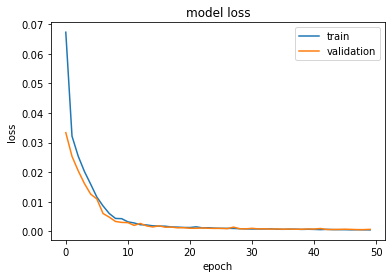

In [141]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [142]:
pred_model_3_y_test_std = model_3.predict(X_test_std)
pred_model_3_y_test = pred_model_3_y_test_std*(ymax-ymin) + ymin
pred_model_3_y_test.shape

(1866, 1)

In [143]:
rmse_lstm_3 = np.sqrt(mean_squared_error(y_test, pred_model_3_y_test))
print("RMSE of Stacked LSTM: ", rmse_lstm_3)
print("I.E. %.04f degree of mean error" % (rmse_lstm_3/math.pi*180))

RMSE of Stacked LSTM:  0.06347140102174237
I.E. 3.6366 degree of mean error


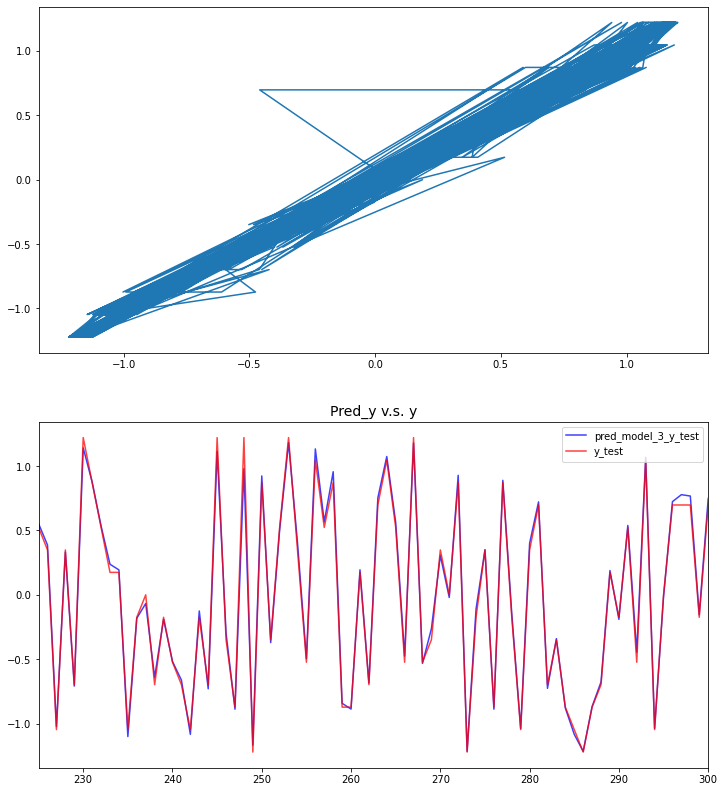

In [144]:
fig ,ax_lst = plt.subplots(2, 1,figsize=(12,14))
ax_lst[0].plot(pred_model_3_y_test, y_test)
ax_lst[1].plot([i for i in range(pred_model_3_y_test.shape[0])], list(pred_model_3_y_test), color='b', alpha=0.75, label='pred_model_3_y_test')
ax_lst[1].plot(y_test, color='red', alpha=0.75, label='y_test')
ax_lst[1].set_title(f"Pred_y v.s. y",fontsize=14)
ax_lst[1].grid(False)
ax_lst[1].legend(loc='upper right')
ax_lst[1].set_xlim([225, 300])
plt.show()

## LSTM-Autoencoder

In [118]:
time_steps = 3
feature_dim = 20 #6

x0 = Input(shape=(time_steps, feature_dim))
l1 = LSTM(128, activation='relu', return_sequences=True)(x0)
l2 = LSTM(64, activation='relu', return_sequences=False)(l1)
h0 = RepeatVector(time_steps)(l2)
l3 = LSTM(64, activation='relu', return_sequences=True)(h0)
l4 = LSTM(128, activation='relu', return_sequences=True)(l3)
r0 = TimeDistributed(Dense(feature_dim))(l4)


LSTM_AE = Model(inputs=x0, outputs=r0)
LSTM_AE_optimizer = keras.optimizers.Adam(learning_rate=0.001)
LSTM_AE.compile(optimizer=LSTM_AE_optimizer, loss='mse')
LSTM_AE.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 20)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 3, 128)            76288     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 3, 64)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 3, 64)             33024     
_________________________________________________________________
lstm_4 (LSTM)                (None, 3, 128)            98816     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 3, 20)             2580

In [119]:
epochs = 100
batch_size = 128

history_lstm_ae = LSTM_AE.fit(X_train_std, X_train_std, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test_std, X_test_std))

Train on 117524 samples, validate on 39175 samples
Epoch 1/100
117524/117524 [==============================] - 11s 90us/step - loss: 0.0195 - val_loss: 0.0025
Epoch 2/100
117524/117524 [==============================] - 10s 83us/step - loss: 0.0010 - val_loss: 7.6689e-04
Epoch 3/100
117524/117524 [==============================] - 10s 83us/step - loss: 5.1337e-04 - val_loss: 5.1917e-04
Epoch 4/100
117524/117524 [==============================] - 10s 83us/step - loss: 3.3563e-04 - val_loss: 2.8651e-04
Epoch 5/100
117524/117524 [==============================] - 10s 83us/step - loss: 2.4173e-04 - val_loss: 2.3925e-04
Epoch 6/100
117524/117524 [==============================] - 10s 82us/step - loss: 1.9300e-04 - val_loss: 2.0790e-04
Epoch 7/100
117524/117524 [==============================] - 10s 83us/step - loss: 1.6199e-04 - val_loss: 3.1348e-04
Epoch 8/100
117524/117524 [==============================] - 10s 82us/step - loss: 1.4106e-04 - val_loss: 1.2166e-04
Epoch 9/100
117524/117524

117524/117524 [==============================] - 10s 83us/step - loss: 2.9223e-05 - val_loss: 3.7860e-05
Epoch 71/100
117524/117524 [==============================] - 10s 83us/step - loss: 2.8135e-05 - val_loss: 3.8478e-05
Epoch 72/100
117524/117524 [==============================] - 10s 84us/step - loss: 2.7769e-05 - val_loss: 2.6106e-05
Epoch 73/100
117524/117524 [==============================] - 10s 83us/step - loss: 2.8064e-05 - val_loss: 3.2138e-05
Epoch 74/100
117524/117524 [==============================] - 10s 83us/step - loss: 2.7295e-05 - val_loss: 4.3008e-05
Epoch 75/100
117524/117524 [==============================] - 10s 83us/step - loss: 2.6979e-05 - val_loss: 3.8886e-05
Epoch 76/100
117524/117524 [==============================] - 10s 83us/step - loss: 2.6597e-05 - val_loss: 2.7120e-05
Epoch 77/100
117524/117524 [==============================] - 10s 85us/step - loss: 2.5985e-05 - val_loss: 2.7256e-05
Epoch 78/100
117524/117524 [==============================] - 10s 83u

In [120]:
pred_X_test_std = LSTM_AE.predict(X_test_std, verbose=0)
print('---Predicted---')
print(np.round(pred_X_test_std, 4))
print('---Actual---')
print(np.round(X_test_std, 4))

---Predicted---
[[[ 9.804e-01  0.000e+00  8.136e-01 ...  4.719e-01  2.642e-01  0.000e+00]
  [ 9.751e-01  0.000e+00  8.108e-01 ...  4.721e-01  2.662e-01  0.000e+00]
  [ 9.744e-01 -0.000e+00  8.124e-01 ...  4.722e-01  2.679e-01  0.000e+00]]

 [[ 2.912e-01  1.000e-04  1.700e-01 ...  7.387e-01  7.663e-01  0.000e+00]
  [ 2.937e-01  1.000e-04  1.679e-01 ...  7.401e-01  7.692e-01  0.000e+00]
  [ 2.948e-01  1.000e-04  1.689e-01 ...  7.421e-01  7.698e-01  0.000e+00]]

 [[ 2.980e-02  0.000e+00  3.802e-01 ...  9.624e-01  9.754e-01  0.000e+00]
  [ 2.940e-02  0.000e+00  3.790e-01 ...  9.650e-01  9.819e-01  0.000e+00]
  [ 2.890e-02  0.000e+00  3.776e-01 ...  9.633e-01  9.794e-01  0.000e+00]]

 ...

 [[ 4.210e-02  1.000e-04  4.124e-01 ...  6.681e-01  4.565e-01  0.000e+00]
  [ 6.220e-02  1.000e-04  4.901e-01 ...  7.929e-01  7.949e-01  0.000e+00]
  [ 5.640e-02  0.000e+00  4.747e-01 ...  7.894e-01  7.905e-01  0.000e+00]]

 [[ 3.645e-01  0.000e+00  4.683e-01 ...  6.743e-01  6.909e-01  1.000e-04]
  [ 3.62

In [121]:
encoder = Model(inputs=x0, outputs=l2)
encoder.compile(optimizer='adam', loss='mse')
encoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 20)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 3, 128)            76288     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
Total params: 125,696
Trainable params: 125,696
Non-trainable params: 0
_________________________________________________________________


In [122]:
# Predict both Train/Test data for further training the Regressor
pred_encoded_X_train_std = encoder.predict(X_train_std)
pred_encoded_X_test_std = encoder.predict(X_test_std)
pred_encoded_X_test_std.shape

(39175, 64)

### Dense-regressor on Encoded R-features

In [123]:
def build_regressor(feature_dim = 64):
    
    
    x = Input(shape=(feature_dim,))
    h1 = Dense(256, activation='relu')(x)
    h2 = Dense(512, activation='relu')(h1)
    h3 = Dense(256, activation='relu')(h2)
    h4 = Dense(128, activation='relu')(h3)
    r = Dense(1, activation='sigmoid')(h4)
    
    return Model(inputs=x, outputs=r)

model_4 = build_regressor(64)
Regressor_optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_4.compile(optimizer=Regressor_optimizer, loss='mse')
model_4.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               16640     
_________________________________________________________________
dense_3 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 312,577
Trainable params: 312,577
Non-trainable params: 0
_____________________________________________________

In [124]:
epochs = 100
batch_size = 128

history_model_4 = model_4.fit(pred_encoded_X_train_std, y_train_std, batch_size=batch_size, epochs=epochs, \
                    verbose=1, validation_data=(pred_encoded_X_test_std, y_test_std))

Train on 117524 samples, validate on 39175 samples
Epoch 1/100
117524/117524 [==============================] - 2s 20us/step - loss: 0.0017 - val_loss: 1.2378e-04
Epoch 2/100
117524/117524 [==============================] - 2s 17us/step - loss: 8.2875e-05 - val_loss: 5.7852e-05
Epoch 3/100
117524/117524 [==============================] - 2s 19us/step - loss: 6.6023e-05 - val_loss: 7.6879e-05
Epoch 4/100
117524/117524 [==============================] - 2s 19us/step - loss: 4.2731e-05 - val_loss: 3.6789e-05
Epoch 5/100
117524/117524 [==============================] - 2s 18us/step - loss: 4.1011e-05 - val_loss: 4.7785e-05
Epoch 6/100
117524/117524 [==============================] - 2s 18us/step - loss: 3.2333e-05 - val_loss: 2.7993e-05
Epoch 7/100
117524/117524 [==============================] - 2s 18us/step - loss: 1.3033e-04 - val_loss: 3.2106e-05
Epoch 8/100
117524/117524 [==============================] - 2s 19us/step - loss: 2.1037e-05 - val_loss: 3.5394e-05
Epoch 9/100
117524/117524

117524/117524 [==============================] - 2s 19us/step - loss: 1.0667e-05 - val_loss: 0.0010
Epoch 71/100
117524/117524 [==============================] - 2s 18us/step - loss: 1.1117e-05 - val_loss: 5.2625e-06
Epoch 72/100
117524/117524 [==============================] - 2s 19us/step - loss: 4.6127e-06 - val_loss: 3.2773e-06
Epoch 73/100
117524/117524 [==============================] - 2s 19us/step - loss: 1.6977e-05 - val_loss: 3.1444e-06
Epoch 74/100
117524/117524 [==============================] - 2s 18us/step - loss: 3.0033e-06 - val_loss: 1.8873e-06
Epoch 75/100
117524/117524 [==============================] - 2s 20us/step - loss: 3.8777e-06 - val_loss: 2.7671e-06
Epoch 76/100
117524/117524 [==============================] - 2s 20us/step - loss: 5.2851e-06 - val_loss: 3.6210e-06
Epoch 77/100
117524/117524 [==============================] - 2s 20us/step - loss: 4.5406e-06 - val_loss: 3.3109e-06
Epoch 78/100
117524/117524 [==============================] - 3s 22us/step - loss

In [125]:
pred_model_4_y_test_std = model_4.predict(pred_encoded_X_test_std)
pred_model_4_y_test = pred_model_4_y_test_std*(ymax-ymin) + ymin

rmse_model_4 = np.sqrt(mean_squared_error(y_test, pred_model_4_y_test))
print("RMSE of LSTM-AE + 4FC: ", rmse_model_4)
print("I.E. %.04f degree of mean error" % (rmse_model_4/math.pi*180))

RMSE of LSTM-AE + 4FC:  0.003733792365242834
I.E. 0.2139 degree of mean error


In [126]:
# Prepare unseen testing data
Xarr1.shape

(2230, 3, 20)

In [127]:
# Normalization
Xarr1_std = mmsc.transform(Xarr1.reshape(-1, Xarr1.shape[-1])).reshape(Xarr1.shape)
print(Xarr1_std.shape)

yarr1 = [item[0] for item in yarr1]
yarr1_std = (yarr1 - ymin)/(ymax-ymin)
print(yarr1_std.shape)

(2230, 3, 20)
(2230,)


In [79]:
# Save and Load models
import pickle

encoder_fc_tuple = (encoder, model_4)

pkl_filename = "encoder_fc_phs_tuple.pkl"
with open(join('checkpoints', pkl_filename), 'wb') as a_file:
    pickle.dump(encoder_fc_tuple, a_file)

In [88]:
pkl_filename = "encoder_fc_tuple.pkl"
with open(join('checkpoints', pkl_filename), 'rb') as a_file:
    encoder_cpy, model_4_cpy = pickle.load(a_file)
    
encoder_cpy.summary()
model_4_cpy.summary()


Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 3, 20)             0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 3, 128)            76288     
_________________________________________________________________
lstm_15 (LSTM)               (None, 64)                49408     
Total params: 125,696
Trainable params: 125,696
Non-trainable params: 0
_________________________________________________________________
Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 64)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 256)               16640     
_________________________________

In [130]:
# Predict output of model_4(encoder(X_train/test))
pred_LSTM_AE_4FC_std = encoder.predict(Xarr1_std)
pred_LSTM_AE_4FC_std = model_4.predict(pred_LSTM_AE_4FC_std)

In [136]:
pred_LSTM_AE_4FC = pred_LSTM_AE_4FC_std*(ymax-ymin) + ymin

rmse_LSTM_AE_4FC = np.sqrt(mean_squared_error(yarr1, pred_LSTM_AE_4FC))
print("RMSE of (LSTM-AE + 4FC) upon unseen data X1: ", rmse_LSTM_AE_4FC)
print("I.E. %.04f degree of mean error" % (rmse_LSTM_AE_4FC/math.pi*180))

RMSE of (LSTM-AE + 4FC) upon unseen data X1:  1.2958695740376447
I.E. 74.2479 degree of mean error


In [138]:
pred_LSTM_AE_4FC[-50:]

array([[-0.49464178],
       [-0.01120532],
       [-0.1323756 ],
       [-0.2354052 ],
       [-0.7904309 ],
       [-0.6551551 ],
       [-0.6844514 ],
       [-0.754794  ],
       [-0.81784993],
       [-0.83040774],
       [-0.621378  ],
       [-0.46684295],
       [-0.6323137 ],
       [ 0.08473301],
       [ 0.11202657],
       [-0.12506592],
       [-1.1714327 ],
       [-0.92208135],
       [-0.65644974],
       [-0.33017933],
       [-0.98589474],
       [-1.0353049 ],
       [-1.0423523 ],
       [-0.9967375 ],
       [-1.2064736 ],
       [-0.20421231],
       [-0.2589702 ],
       [-0.16911352],
       [ 0.08730483],
       [-0.04280186],
       [-0.27899408],
       [-0.27344656],
       [-1.0335972 ],
       [-1.0870221 ],
       [-0.98704934],
       [ 0.5487189 ],
       [ 0.25472498],
       [-0.2962188 ],
       [-0.30624717],
       [ 0.15688586],
       [-0.72529054],
       [-0.7608493 ],
       [-0.3660044 ],
       [-0.3461054 ],
       [-0.32607478],
       [-0

### Build end-to-end Encoder+FC model
Perform poorer than two-stage inference

In [62]:
# Build encoder_fc model
fc1 = Dense(256, activation='relu')(l2)
fc2 = Dense(512, activation='relu')(fc1)
fc3 = Dense(256, activation='relu')(fc2)
fc4 = Dense(128, activation='relu')(fc3)
fc_out = Dense(1, activation='sigmoid')(fc4)

model_encoder_fc = Model(inputs=x0, outputs=fc_out)

Encoder_fc_optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_encoder_fc.compile(optimizer=Encoder_fc_optimizer, loss='mse')
model_encoder_fc.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3, 6)              0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 3, 128)            69120     
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_20 (Dense)             (None, 256)               16640     
_________________________________________________________________
dense_21 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_22 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_23 (Dense)             (None, 128)               3289

In [63]:
epochs = 50
batch_size = 128

history_model_encoder_fc = model_encoder_fc.fit(X_train_std, y_train_std, batch_size=batch_size, epochs=epochs, \
                    verbose=1, validation_data=(X_test_std, y_test_std))

Train on 117524 samples, validate on 39175 samples
Epoch 1/50
117524/117524 [==============================] - 13s 110us/step - loss: 0.0191 - val_loss: 0.0110
Epoch 2/50
117524/117524 [==============================] - 12s 104us/step - loss: 0.0083 - val_loss: 0.0074
Epoch 3/50
117524/117524 [==============================] - 12s 103us/step - loss: 0.0067 - val_loss: 0.0054
Epoch 4/50
117524/117524 [==============================] - 12s 103us/step - loss: 0.0062 - val_loss: 0.0050
Epoch 5/50
117524/117524 [==============================] - 12s 103us/step - loss: 0.0053 - val_loss: 0.0077
Epoch 6/50
117524/117524 [==============================] - 12s 103us/step - loss: 0.0053 - val_loss: 0.0046
Epoch 7/50
117524/117524 [==============================] - 12s 104us/step - loss: 0.0052 - val_loss: 0.0048
Epoch 8/50
117524/117524 [==============================] - 13s 108us/step - loss: 0.0051 - val_loss: 0.0048
Epoch 9/50
117524/117524 [==============================] - 13s 110us/step - 

In [64]:
pred_model_encoder_fc_y_test_std = model_encoder_fc.predict(X_test_std)
pred_model_encoder_fc_y_test = pred_model_encoder_fc_y_test_std*(ymax-ymin) + ymin

rmse_model_encoder_fc = np.sqrt(mean_squared_error(y_test, pred_model_encoder_fc_y_test))
print("RMSE of ENCODER-FC: ", rmse_model_encoder_fc)
print("I.E. %.04f degree of mean error" % (rmse_model_encoder_fc/math.pi*180))

RMSE of ENCODER-FC:  0.13473411310627467
I.E. 7.7197 degree of mean error


### SVR on Encoded R-features (Optional)

In [135]:
# SVR
svr_ae = SVR(kernel='rbf',gamma='scale', C=5.0, epsilon=0.01)
svr_ae.fit(pred_encoded_X_train_std, y_train)
svr_ae.score(pred_encoded_X_test_std, y_test)

0.9829883088464295

In [75]:
'''
params = {'C':[0.01,0.05,0.1,0.5,1,2,5],'epsilon':[0.1,0.2,0.5,1]}
grid = GridSearchCV(svr_3,param_grid=params,cv=5,scoring='r2',verbose=1,return_train_score=True)
grid.fit(pred_encoded_X_train_std, y_train)
print(grid.best_estimator_)
print(grid.best_score_)
'''

"\nparams = {'C':[0.01,0.05,0.1,0.5,1,2,5],'epsilon':[0.1,0.2,0.5,1]}\ngrid = GridSearchCV(svr_3,param_grid=params,cv=5,scoring='r2',verbose=1,return_train_score=True)\ngrid.fit(pred_encoded_X_train_std, y_train)\nprint(grid.best_estimator_)\nprint(grid.best_score_)\n"

In [180]:
with open(join('checkpoints', 'svr_ae.pkl'), 'wb') as a_file:
    pickle.dump(svr_ae, a_file)

In [ ]:
with open(join('checkpoints', 'svr_ae.pkl'), 'rb') as a_file:
    svr_ae = pickle.load(a_file)

In [138]:
pred_EncodeSVR_y_test = svr_ae.predict(pred_encoded_X_test_std)
rmse_svr_ae = np.sqrt(mean_squared_error(y_test, pred_EncodeSVR_y_test))
print("RMSE for LSTM-AE + SVR:", rmse_svr_ae)
print("I.E. %.04f degree of mean error" % (rmse_svr_ae/math.pi*180))

RMSE for LSTM-AE + SVR: 0.09562362322617296
I.E. 5.4788 degree of mean error


In [139]:
len(y_test)

39175

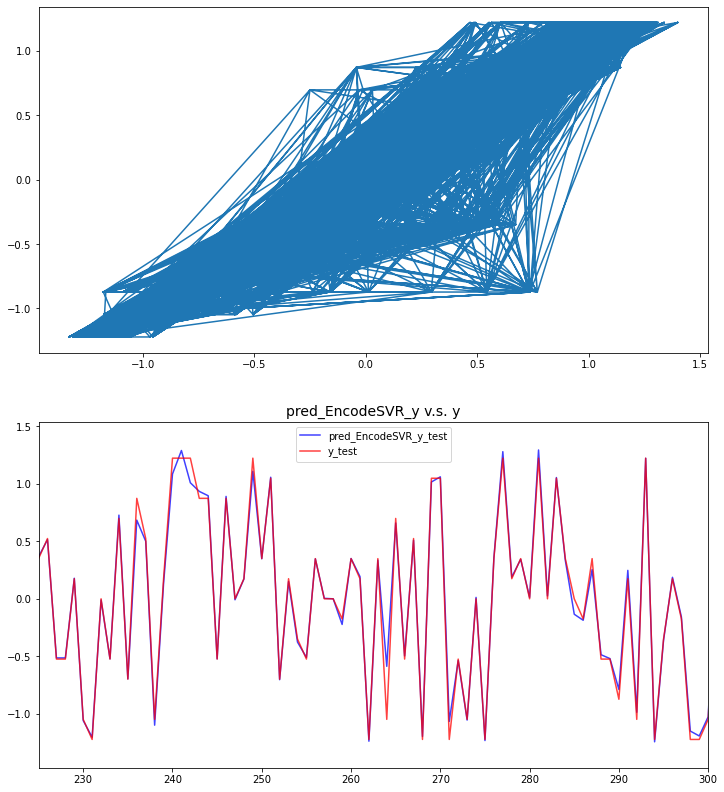

In [140]:
fig ,ax_lst = plt.subplots(2, 1,figsize=(12,14))
ax_lst[0].plot(pred_EncodeSVR_y_test, y_test)
ax_lst[1].plot([i for i in range(pred_EncodeSVR_y_test.shape[0])], list(pred_EncodeSVR_y_test), color='b', alpha=0.75, label='pred_EncodeSVR_y_test')
ax_lst[1].plot(y_test, color='red', alpha=0.75, label='y_test')
ax_lst[1].set_title(f"pred_EncodeSVR_y v.s. y",fontsize=14)
ax_lst[1].grid(False)
ax_lst[1].legend(loc='best')
ax_lst[1].set_xlim([225, 300])
plt.show()

### Visualize CDF

In [141]:
y_err_series = pd.Series(abs(y_test - pred_EncodeSVR_y_test) / math.pi*180)

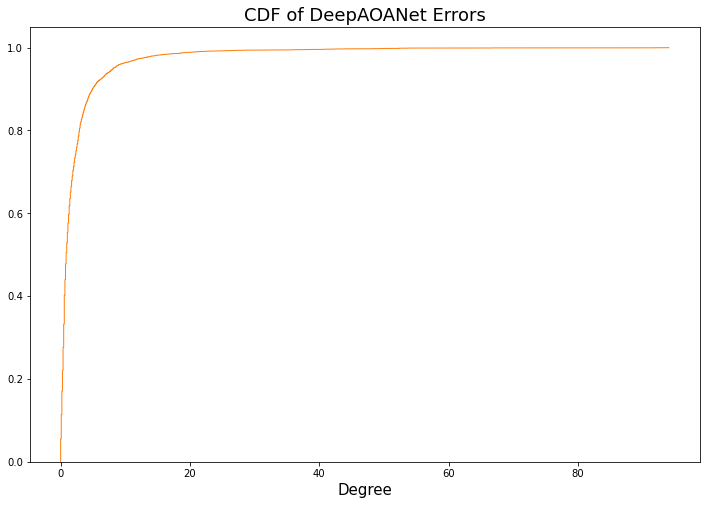

In [142]:
fig_hist, ax_hist = plt.subplots(1,1, figsize=(12,8))
n, bins, patches = ax_hist.hist(y_err_series, density=True, cumulative = True, histtype='step', bins=1000, color='tab:orange')
patches[0].set_xy(patches[0].get_xy()[:-1])
ax_hist.set_title("CDF of DeepAOANet Errors", fontsize=18)
ax_hist.set_xlabel("Degree", fontsize=15)
plt.show()

### Directly apply SVR on Rjk

In [154]:
# Xsingle equivalent to Xvec_clean
print(np.argwhere(np.isnan(yvec)), np.argwhere(np.isnan(yvec_clean)))

[] []


In [155]:
Xsingle = Xvec[~np.isnan(Xvec).any(axis=1)]
ysingle0 = yvec[~np.isnan(yvec).any(axis=1)]
ysingle = [item[0] for item in ysingle0]

In [156]:
X_train0, X_test0, y_train0, y_test0 = train_test_split(Xsingle, ysingle, test_size=0.7, random_state=42)

In [157]:
svr_0 = SVR(kernel='rbf',gamma='scale', C=5.0, epsilon=0.01)
svr_0.fit(X_train0, y_train0)
svr_0.score(X_test0, y_test0)

0.8966726953106208

In [181]:
# Save SVR
with open(join('checkpoints', 'svr_0.pkl'), 'wb') as a_file:
    pickle.dump(svr_0, a_file)

In [ ]:
with open(join('checkpoints', 'svr_0.pkl'), 'rb') as a_file:
    svr_0 = pickle.load(a_file)

In [158]:
pred_SVR0_y_test = svr_0.predict(X_test0)
rmse0 = np.sqrt(mean_squared_error(y_test0, pred_SVR0_y_test))
print("RMSE for SVR0:", rmse0)
print("I.E. %.04f degree of mean error" % (rmse0/math.pi*180))

RMSE for SVR0: 0.23712279870892275
I.E. 13.5861 degree of mean error


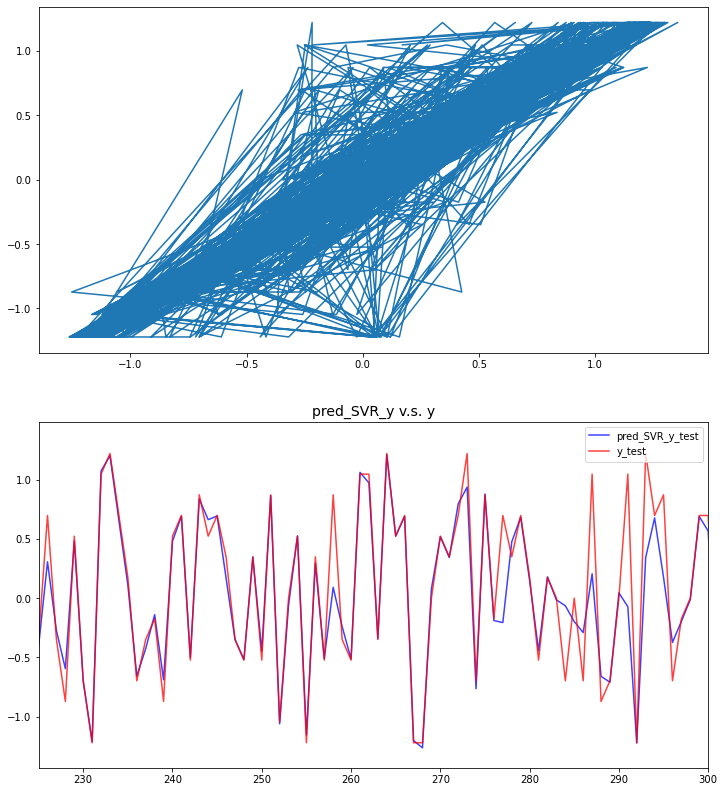

In [159]:
fig0 ,ax_lst0 = plt.subplots(2, 1,figsize=(12,14))
ax_lst0[0].plot(pred_SVR0_y_test[:2000], y_test0[:2000])
ax_lst0[1].plot([i for i in range(pred_SVR0_y_test.shape[0])], list(pred_SVR0_y_test), color='b', alpha=0.75, label='pred_SVR_y_test')
ax_lst0[1].plot(y_test0, color='red', alpha=0.75, label='y_test')
ax_lst0[1].set_title(f"pred_SVR_y v.s. y",fontsize=14)
ax_lst0[1].grid(False)
ax_lst0[1].legend(loc='best')
ax_lst0[1].set_xlim([225, 300])
plt.show()

# CDF

In [160]:
y_err_music_series = pd.Series(abs(y_test[i] / math.pi*180 - y_test_music[i]) for i in range(len(y_test)))

In [161]:
#y_err_lstm_ae_svr_series = pd.Series(abs(y_test - pred_EncodeSVR_y_test) / math.pi*180)

In [162]:
y_err_svr0_series = pd.Series(abs(y_test0 - pred_SVR0_y_test) / math.pi*180)

In [163]:
y_err_lstm_ae_fc_series = pd.Series(abs(y_test - pred_model_4_y_test.ravel()) / math.pi*180)

In [164]:
y_err_lstm_stacked_lstm_series = pd.Series(abs(y_test - pred_model_3_y_test.ravel()) / math.pi*180)

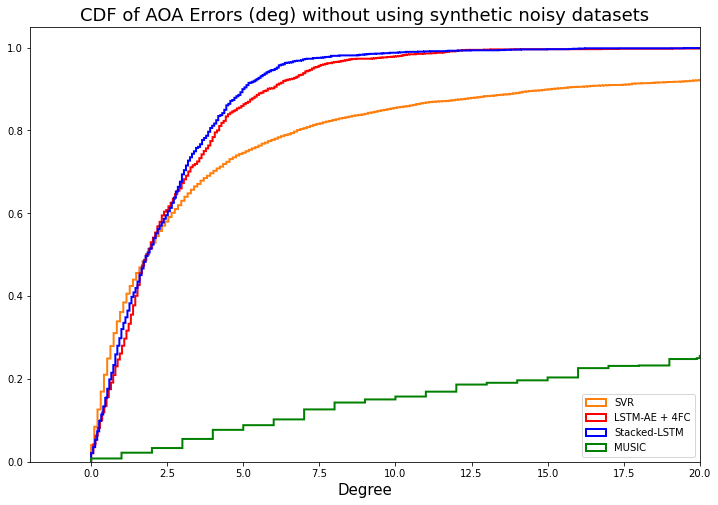

In [165]:
%matplotlib inline
fig_hist, ax_hist = plt.subplots(1,1, figsize=(12,8))
'''
n, bins, patches = ax_hist.hist(y_err_lstm_ae_svr_series, density=True, cumulative = True, histtype='step', \
                                bins=1000, color='tab:orange', linewidth=2, label='LSTM-AE + SVR')
patches[0].set_xy(patches[0].get_xy()[:-1])
'''
n, bins, patches = ax_hist.hist(y_err_svr0_series, density=True, cumulative = True, histtype='step', \
                                bins=1000, color='tab:orange', linewidth=2, label='SVR')
patches[0].set_xy(patches[0].get_xy()[:-1])
n2, bins2, patches2 = ax_hist.hist(y_err_lstm_ae_fc_series, density=True, cumulative = True, histtype='step', \
                                   bins=1000, color='red', linewidth=2, label='LSTM-AE + 4FC')
patches2[0].set_xy(patches2[0].get_xy()[:-1])
n3, bins3, patches3 = ax_hist.hist(y_err_lstm_stacked_lstm_series, density=True, cumulative = True, histtype='step', \
                                   bins=1000, color='b', linewidth=2, label='Stacked-LSTM')
patches3[0].set_xy(patches3[0].get_xy()[:-1])
n4, bins4, patches4 = ax_hist.hist(y_err_music_series, density=True, cumulative = True, histtype='step', \
                                   bins=1000, color='g', linewidth=2, label='MUSIC')
patches4[0].set_xy(patches4[0].get_xy()[:-1])

ax_hist.set_title("CDF of AOA Errors (deg) without using synthetic noisy datasets", fontsize=18)
ax_hist.set_xlabel("Degree", fontsize=15)
ax_hist.set_xlim(-2, 20)
ax_hist.legend(loc='lower right')

fig_hist.savefig(join('doc', 'CDF_R_pure3.png'), facecolor="w", bbox_inches='tight')
plt.show()

# Validation
### (1) Unseen NLOS Data [-45, 0, 45]

In [81]:
fields_lst = ['field.data0', 'field.data1', 'field.data2', 'field.data3', 'field.data4', 'field.data5', 'field.data6', 'field.data7', \
              'field.data10', 'field.data11', 'field.data12', 'field.data13', 'field.data14', 'field.data15', \
              'field.data20', 'field.data21', 'field.data22', 'field.data23', \
              'field.data30', 'field.data31']
new_col = ['r12', 'r13', 'r14', 'r23', 'r24', 'r34']
# Show detection of LoRa beacon when Rjk is significant
field_thres = 1e-04

In [82]:
test_dict = {}
test_dir = join('data_1606', 'test')

for filename in os.listdir(test_dir):
    if filename.startswith("test_m") and filename.endswith(".csv"):
        aoa = pd.read_csv(join(test_dir, filename), sep=',', header=0)
        aoa_Rjk = aoa[fields_lst]
        test_dict[- float(filename[6:-4])] = aoa_Rjk
    elif filename.startswith("test_") and filename.endswith(".csv"):
        aoa = pd.read_csv(join(test_dir, filename), sep=',', header=0)
        aoa_Rjk = aoa[fields_lst]
        test_dict[float(filename[5:-4])] = aoa_Rjk

In [83]:
test_sig = {}
test_sig_index = {}

for key in test_dict.keys():
    test_dict[key]['theta'] = key * math.pi / 180
    test_sig_index[key] = (test_dict[key][abs(test_dict[key]['field.data2']) < field_thres].index)
    test_sig[key] = test_dict[key].iloc[test_sig_index[key], :]

Xtest = pd.concat([test_sig[rad] for rad in test_dict.keys()], \
                 keys=[rad for rad in test_dict.keys()], names=['Series name', 'Row ID'])
Xtest['music'] = pd.Series([0] * len(Xtest.index))

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [89]:
Xtest.shape

(3111, 22)

In [90]:
# CREATE: If using R_phase as input feature
Xphs_test2, Xamp_test2 = [], []
for item in [Xtest]:
    phs, amp = create_Xphs_Xamp(item)
    Xphs_test2.append(phs)
    Xamp_test2.append(amp)
    
Xphs_test2[0]

r12       r13       r14       r23  r24       r34  \
Series name Row ID                                                     
-45.0       0       0.0 -0.584400 -2.562005 -1.698066  0.0 -2.149339   
            1       0.0 -0.435424 -2.517031 -1.727634  0.0 -1.703768   
            2       0.0 -1.983908 -2.656720 -1.502667  0.0  0.189015   
            3       0.0 -0.540016 -2.599287 -1.844297  0.0 -2.151937   
            15      0.0 -0.457718 -2.506565 -1.714339  0.0 -2.113907   
...                 ...       ...       ...       ...  ...       ...   
 45.0       1700    0.0 -0.680340 -2.799323 -0.808793  0.0 -2.554681   
            1701    0.0 -0.235561 -2.661797 -0.823952  0.0 -2.332732   
            1702    0.0  0.092232 -2.675180 -0.743071  0.0 -2.680688   
            1703    0.0 -0.340383 -2.803112 -0.903844  0.0 -2.574776   
            1704    0.0 -0.114608 -2.746498 -0.858374  0.0 -2.731961   

                       theta  music  
Series name Row ID                   
-45.0       0      -0.785398    NaN  
            1      -0.785398    NaN  
            2      -0.785398    NaN  
            3      -0.785398    NaN  
            15     -0.785398    NaN  
...                      ...    ...  
 45.0       1700    0.785398    NaN  
            1701    0.785398    NaN  
            1702    0.785398    NaN  
            1703    0.785398    NaN  
            1704    0.785398    NaN  

[3111 rows x 8 columns]

In [93]:
# SPLIT
for item in Xphs_test2:
    Xtest_arr, ytest_lst2, Xtest_vec, ytest_vec = Split_TimeSeries3(item, aoa_gt_series=range(-45, 90, 45), \
                                                                   feature_space=6)
    
Xtest_arr.shape

(2949, 3, 6)

In [105]:
ytest_vec.shape

(3111, 2)

In [94]:
# SHUFFLE
X_train_null, X_test2, y_train_null, y_test2 = train_test_split(Xtest_arr, ytest_lst2, test_size=0.9, random_state=42)

In [106]:
print(X_test2.shape, len(y_test2))

(2655, 3, 6) 2655


In [98]:
# Normalization
X_test2_std = mmsc.transform(X_test2.reshape(-1, X_test2.shape[-1])).reshape(X_test2.shape)

y_test2_lst = [item[0] for item in y_test2]
y_test2_lst_std = (y_test2_lst - ymin)/(ymax-ymin)

In [99]:
# Stacked LSTM
pred_X_test2_std = model_3.predict(X_test2_std)
pred_X_test2 = pred_X_test2_std*(ymax - ymin) + ymin

pred_X_test2_std.shape

(2655, 1)

In [100]:
rmse_lstm_model_3_test2 = np.sqrt(mean_squared_error(y_test2_lst, pred_X_test2_std))
print("RMSE of Stacked LSTM: ", rmse_lstm_model_3_test2)
print("I.E. %.04f degree of mean error" % (rmse_lstm_model_3_test2/math.pi*180))

RMSE of Stacked LSTM:  0.6765697700547708
I.E. 38.7646 degree of mean error


In [101]:
# Encoder-SVR
pred_EncoderSVR_ytest_lst = svr_ae.predict(encoder.predict(X_test2_std))

rmse_EncoderSVR = np.sqrt(mean_squared_error(y_test2_lst, pred_EncoderSVR_ytest_lst))
print("RMSE of LSTM-Encoder + SVR: ", rmse_EncoderSVR)
print("I.E. %.04f degree of mean error" % (rmse_EncoderSVR/math.pi*180))

NameError: name 'svr_ae' is not defined

In [102]:
# Encoder-FC
pred_EncoderFC_ytest_lst = model_4.predict(encoder.predict(X_test2_std))

rmse_EncoderFC = np.sqrt(mean_squared_error(y_test2_lst, pred_EncoderFC_ytest_lst))
print("RMSE of LSTM-Encoder + FC: ", rmse_EncoderFC)
print("I.E. %.04f degree of mean error" % (rmse_EncoderFC/math.pi*180))

RMSE of LSTM-Encoder + FC:  0.6500714798665922
I.E. 37.2464 degree of mean error


In [108]:
# DirectSVR
#X_train_null, X_test2vec, y_train_null, y_test2vec = train_test_split(Xtest_vec, ytest_vec, test_size=0.9, random_state=42)
pred_SVR_0_X_test2 = svr_0.predict(X_test2[:, 0, :])
rmse_svronly2 = np.sqrt(mean_squared_error(y_test2_lst, pred_SVR_0_X_test2))
print("RMSE for SVR-Only:", rmse_svronly2)
print("I.E. %.04f degree of mean error" % (rmse_svronly2/math.pi*180))

RMSE for SVR-Only: 1.0544157098489537
I.E. 60.4136 degree of mean error


### (2) Test with UNSEEN data